# AT&T - DEEP LEARNING PROJET

# 1. Import librairies

In [4]:
# prevent warning
import warnings
warnings.filterwarnings("ignore")

# clear outputs
from IPython.display import clear_output

# base lib
import pandas as pd
import numpy as np
import chardet
from sklearn.model_selection import train_test_split

# viz lib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# preprocess lib
import tiktoken

# Pytorch lib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary

# import lib transformer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import Dataset as dset

# statistics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# controle device ligne
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device_name = torch.cuda.get_device_name(0)

print("Device actuel :", device)
print("CUDA disponible :", torch.cuda.is_available())
print("Nombre de GPU :", torch.cuda.device_count())
print("Nom GPU :", torch.cuda.get_device_name(0))

Device actuel : 0
CUDA disponible : True
Nombre de GPU : 1
Nom GPU : NVIDIA GeForce GTX 1650


# 2. Import the dataset
"https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"

In [5]:
csv_path = "spam.csv"

In [6]:
# Find an encoding that works
with open(csv_path, "rb") as original_file:
    data_to_decode = original_file.read()
encoding_result = chardet.detect(data_to_decode)
detected_encoding = encoding_result["encoding"]
print("Detected encoding : ",detected_encoding)

encodings_to_try = ['utf-8','utf-16', 'utf-8-sig', 'utf_32', 'utf_32_be', 'utf_32_le', 'utf_7', 'cp1252', 'ISO-8859-1','latin','latin9']

for enc in encodings_to_try:
    try:
        df = pd.read_csv(csv_path, encoding=enc)
        print(f"✅ Loaded successfully with encoding : {enc}")
    except UnicodeDecodeError:
        print(f"❌ Failed with encoding : {enc}")

Detected encoding :  Windows-1252
❌ Failed with encoding : utf-8
❌ Failed with encoding : utf-16
❌ Failed with encoding : utf-8-sig
❌ Failed with encoding : utf_32
❌ Failed with encoding : utf_32_be
❌ Failed with encoding : utf_32_le
❌ Failed with encoding : utf_7
✅ Loaded successfully with encoding : cp1252
✅ Loaded successfully with encoding : ISO-8859-1
✅ Loaded successfully with encoding : latin
✅ Loaded successfully with encoding : latin9


In [7]:
# Load data with encoding cp1252
df = pd.read_csv(csv_path, encoding='cp1252')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# 3. Read data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
df.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


It appears that some messages have been split into multiple columns.

# 4. Preprocessing

In [10]:
# Copy data to make sure you don't have to reimport it
df_v1 = df.copy(deep=True)
df_v1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
# Merge columns
for i in range(2,5,1):
    df_v1[f'Unnamed: {i}'] = df_v1[f'Unnamed: {i}'].fillna("")

df_v1['v2']=pd.concat([df_v1['v2'],df_v1['Unnamed: 2'],df_v1['Unnamed: 3'],df_v1['Unnamed: 4']], ignore_index=True)

df_v1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [12]:
# Rename columns and drop the empty ones
df_v1 = df_v1[['v1', 'v2']].set_axis(['label', 'text'], axis=1)
df_v1.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Transform ham/spam labels into => 0/1
df_v1['label'] = df_v1['label'].map({'ham':0,'spam':1})
df_v1.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# Calculate the percentage of spam in the entire corpus
percent = (df_v1['label'].mean())*100
print(f'Percentage of spam in the corpus: {percent:,.2f} %')

Percentage of spam in the corpus: 13.41 %


# 5. Simple deep learning model

## 5.1 Preprocessing for embedding work

We will now go through a preprocessing phase. The goal is to convert the character strings into sequences of tokens represented by integers.

1. We use the tiktoken library in order to tokenize each sentence based on the `cl100k_base` tokenizer.

In [15]:
tokenizer = tiktoken.get_encoding("cl100k_base")

def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

train_tokens = encode_texts(df_v1['text'])

# print the first ten tokens of the first tokenized sentence
train_tokens[0][:10]

[11087, 3156, 16422, 647, 1486, 11, 14599, 497, 16528, 1193]

2. In order to build the data loader, we need all sequences to be of the same length. We calculate the max and average senquence length, and decide which length we want all sequences to adopt.

avg seq len : 22.48707824838478
max seq len : 259
min seq len : 1


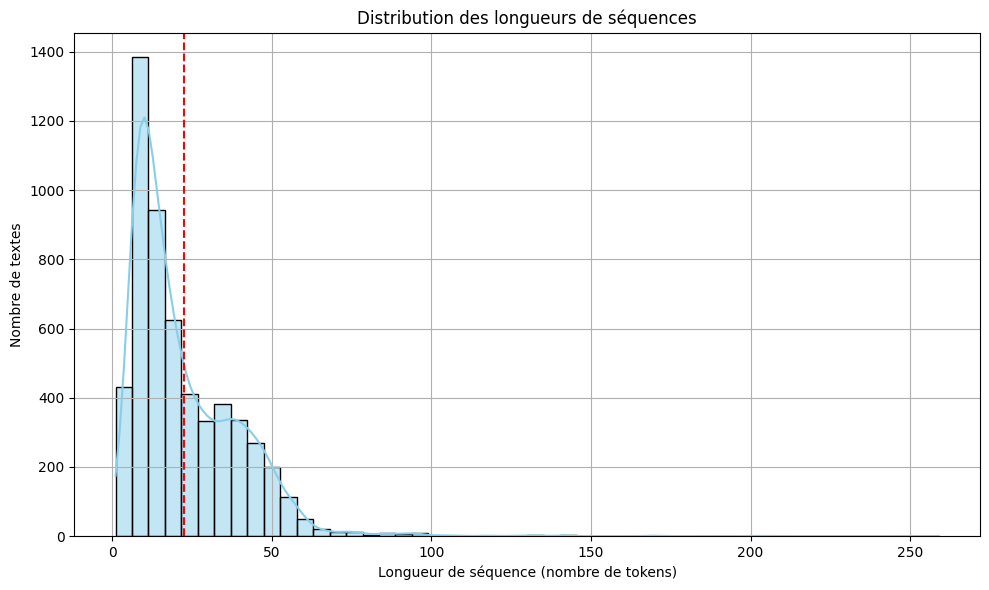

In [16]:
# Longueurs des séquences
seq_lens = [len(seq) for seq in train_tokens]

# Statistiques utiles
print("avg seq len :", np.mean(seq_lens))
print("max seq len :", np.max(seq_lens))
print("min seq len :", np.min(seq_lens))

# Tracé de l’histogramme
plt.figure(figsize=(10, 6))
sns.histplot(seq_lens, bins=50, kde=True, color='skyblue')
plt.title("Distribution des longueurs de séquences")
plt.xlabel("Longueur de séquence (nombre de tokens)")
plt.ylabel("Nombre de textes")
plt.axvline(x=np.mean(seq_lens), color='red', linestyle='--', label='Moyenne')
plt.grid(True)
plt.tight_layout()
plt.show()



We estimate that a padding sequence of 200 would be sufficient.

In [17]:
def pad_sequences(sequences, max_length=200):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens = pad_sequences(train_tokens)

3. We form a torch dataset object based on the token sequences and labels, and split the data into a train and validation set.

In [18]:
# Define a custom PyTorch dataset class for SPAM detection
class SPAMDataset(Dataset):
    """
    A custom dataset class for SPAM detection.

    This class is used to convert text data (already tokenized) and their corresponding labels
    into a PyTorch Dataset object, which can be easily loaded into a DataLoader.
    """

    def __init__(self, texts, labels):
        """
        Initializes the dataset by storing texts and labels as PyTorch tensors.

        Args:
        - texts (list or numpy array): Tokenized text data, where each text has been converted
                                       into a sequence of word indices (integer tokens).
        - labels (list or numpy array): The corresponding labels for each text .
        """
        # Convert text sequences to a PyTorch tensor (long type since they are indices)
        self.texts = torch.tensor(texts, dtype=torch.long)

        # Convert labels to a PyTorch tensor (float32 for compatibility with loss functions)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        This method is required for PyTorch datasets as it allows DataLoader to determine
        how many batches it needs.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single data point (text and label) from the dataset based on an index.

        Args:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - tuple: A tuple containing:
            - self.texts[idx]: The tokenized text at index `idx`.
            - self.labels[idx]: The corresponding label for that text.
        """
        return self.texts[idx], self.labels[idx]

# Example usage: Creating a dataset instance
df_dataset = SPAMDataset(train_tokens, df_v1['label'])

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(df_dataset))
val_size = len(df_dataset) - train_size
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
text, label = next(iter(train_loader))
print(label)
print(text)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[   40,   649,   956,  ...,     0,     0,     0],
        [ 9642,   497,   383,  ...,     0,     0,     0],
        [ 7749, 41698,    11,  ...,     0,     0,     0],
        ...,
        [   45,    83,  1193,  ...,     0,     0,     0],
        [ 2675,  1436,   617,  ...,     0,     0,     0],
        [27125,  1099,    23,  ...,     0,     0,     0]])


We have imported data corresponding to spam classication organized in binary categories.   
We'll load the text data into python variables.

## 5.2 Creating model

In [20]:
# Get the vocabulary size from the tokenizer
# This represents the total number of unique words in the dataset,
# which will be used as the input size for the embedding layer.

vocab_size = tokenizer.n_vocab

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        """
        Initializes the model layers.

        Args:
        - vocab_size (int): The number of unique words in the vocabulary.
        - embed_dim (int): The size of each word's embedding vector.
        """
        super(TextClassifier, self).__init__()
        
        # Embedding layer: Maps word indices to dense vector representations
        # padding_idx=0 ensures that padding tokens (index 0) do not contribute to learning
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Adaptive Average Pooling: Computes the average of the word embeddings along the sequence length
        # This helps reduce variable-length text into a fixed-size representation
        self.pooling = nn.AdaptiveAvgPool1d(1)
        
        # Fully Connected (Linear) layer: Maps the fixed-size vector to the number of classes
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        """
        Defines the forward pass of the model.

        Args:
        - text (Tensor): A batch of tokenized text (word indices).

        Returns:
        - Tensor: The predicted output (e.g., a continuous score or rating).
        """
        # Convert input word indices into dense embeddings
        embedded = self.embedding(text)

        # Permute to match the expected shape for pooling: (batch, channels, sequence_length)
        # Then, apply average pooling to reduce sequence length to 1
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        # Pass the pooled embeddings through the linear layer to get the final prediction
        # Sigmoid is for making prediction between 0 and 1
        return torch.sigmoid(self.fc(pooled))


# Create an instance of the model
model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=16,
                      num_class=1)

In [21]:
print(model)

# Print model summary
summary(model, input_data=text)

TextClassifier(
  (embedding): Embedding(100277, 16, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 200, 16]             1,604,432
├─AdaptiveAvgPool1d: 1-2                 [32, 16, 1]               --
├─Linear: 1-3                            [32, 1]                   17
Total params: 1,604,449
Trainable params: 1,604,449
Non-trainable params: 0
Total mult-adds (M): 51.34
Input size (MB): 0.05
Forward/backward pass size (MB): 0.82
Params size (MB): 6.42
Estimated Total Size (MB): 7.29

## 5.3 Training model

In [22]:
# Compile the model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=200, device=device):
    """
    Function to train a PyTorch model with training and validation datasets.

    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).

    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss

            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions


        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)


        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                model = model.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=60, 
                device=device)

Epoch [1/60], Loss: 0.6881, Acc: 0.5623, Val Loss: 0.6576, Val Acc: 0.8673
Epoch [2/60], Loss: 0.6264, Acc: 0.8656, Val Loss: 0.5933, Val Acc: 0.8673
Epoch [3/60], Loss: 0.5604, Acc: 0.8663, Val Loss: 0.5260, Val Acc: 0.8673
Epoch [4/60], Loss: 0.4925, Acc: 0.8735, Val Loss: 0.4597, Val Acc: 0.8753
Epoch [5/60], Loss: 0.4287, Acc: 0.8892, Val Loss: 0.3992, Val Acc: 0.8960
Epoch [6/60], Loss: 0.3711, Acc: 0.9085, Val Loss: 0.3478, Val Acc: 0.9157
Epoch [7/60], Loss: 0.3229, Acc: 0.9253, Val Loss: 0.3043, Val Acc: 0.9318
Epoch [8/60], Loss: 0.2809, Acc: 0.9403, Val Loss: 0.2682, Val Acc: 0.9417
Epoch [9/60], Loss: 0.2463, Acc: 0.9509, Val Loss: 0.2379, Val Acc: 0.9480
Epoch [10/60], Loss: 0.2169, Acc: 0.9576, Val Loss: 0.2129, Val Acc: 0.9578
Epoch [11/60], Loss: 0.1926, Acc: 0.9623, Val Loss: 0.1921, Val Acc: 0.9614
Epoch [12/60], Loss: 0.1721, Acc: 0.9675, Val Loss: 0.1746, Val Acc: 0.9659
Epoch [13/60], Loss: 0.1555, Acc: 0.9722, Val Loss: 0.1599, Val Acc: 0.9713
Epoch [14/60], Loss: 

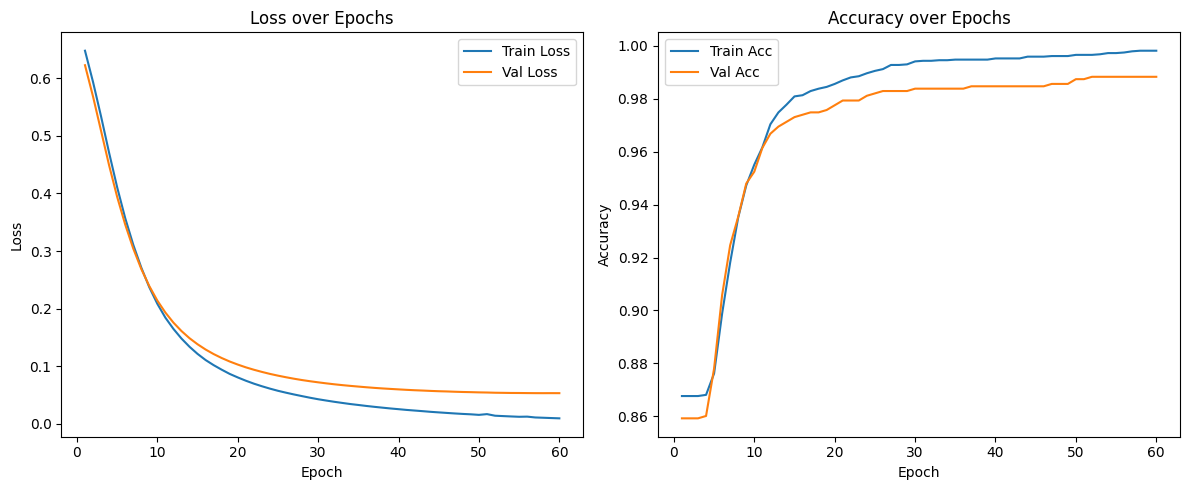

In [20]:
# Plotting evolution of loss & accuracy during training

epochs = range(1, len(history['loss'])+1)

plt.figure(figsize=(12, 5))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Train Acc')
plt.plot(epochs, history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## 5.4 Error analysis

### Worst predictions

In [21]:
# Function to evaluate the model and get worst predictions
def evaluate_worst_predictions(model, dataloader, tokenizer, device=device):
    model.eval()  # Set model to evaluation mode
    
    all_predictions = []
    all_labels = []
    all_errors = []
    all_inputs = []

    with torch.no_grad():  # No gradients needed during evaluation
        for batch in dataloader:
            inputs, labels = batch  # Assuming (inputs, labels) in DataLoader
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            model.to(device)
            outputs = model(inputs)

            # Convert outputs to predicted class (for classification)
            if outputs.shape[-1] > 1:  # Multi-class classification
                preds = torch.argmax(outputs, dim=1)
                errors = (preds != labels).float()  # Misclassified observations
            else:  # Regression
                preds = outputs.squeeze()
                errors = torch.abs(preds - labels)  # Absolute error

            # Save results
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_errors.extend(errors.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    # Convert to DataFrame for analysis
    df_results = pd.DataFrame({
        "True_Label": all_labels,
        "Predicted": all_predictions,
        "Error": all_errors,
        "Inputs": all_inputs,
        "Text" : [tokenizer.decode(input) for input in all_inputs]
    })

    # Sort by highest error (worst predictions)
    df_results_sorted = df_results.sort_values(by="Error", ascending=False)

    return df_results_sorted

# Example usage:
worst_predictions_val = evaluate_worst_predictions(model, val_loader, tokenizer, device=device)
worst_predictions_train = evaluate_worst_predictions(model, train_loader, tokenizer, device=device)


In [22]:
worst_predictions_train.head(10)

,True_Label,Predicted,Error,Inputs,Text
640,1.0,0.064870,0.935130,"[5519, 499, 3596, 5406, 430, 994, 499, 2351, 1...","Do you ever notice that when you're driving, a..."
2506,1.0,0.116073,0.883927,"[29089, 499, 1093, 311, 1518, 856, 20572, 2206...",Would you like to see my XXX pics they are so ...
3668,1.0,0.123619,0.876381,"[19701, 358, 13942, 701, 1650, 1095, 596, 3137...",Sorry I missed your call let's talk when you h...
4436,1.0,0.142348,0.857652,"[5519, 499, 13383, 430, 304, 922, 220, 1272, 1...","Do you realize that in about 40 years, we'll h..."
506,1.0,0.171248,0.828752,"[43, 40777, 706, 2646, 1027, 420, 1790, 2523, ...",LIFE has never been this much fun and great un...
3291,1.0,0.270130,0.729870,"[25821, 602, 617, 2834, 3243, 287, 1396, 220, ...",Money i have won wining number 946 wot do i do...
4423,1.0,0.471344,0.528656,"[4438, 2586, 433, 5097, 779, 2697, 892, 369, 2...",How come it takes so little time for a child w...
2241,1.0,0.483943,0.516057,"[9906, 13, 1226, 1205, 1063, 1153, 71, 20229, ...",Hello. We need some posh birds and chaps to us...
1855,1.0,0.553327,0.446673,"[33092, 5513, 0, 10289, 8216, 27306, 23130, 11...","Latest News! Police station toilet stolen, cop..."
870,1.0,0.558536,0.441464,"[12928, 59029, 10789, 220, 24344, 5833, 0, 0, ...",ringtoneking 84484!!!!!!!!!!!!!!!!!!!!!!!!!!!!...


In [23]:
worst_predictions_val.head(10)

,True_Label,Predicted,Error,Inputs,Text
242,1.0,0.000056,0.999944,"[9906, 76745, 1268, 527, 499, 3432, 30, 358, 1...",Hello darling how are you today? I would love ...
205,1.0,0.000167,0.999833,"[10149, 577, 3449, 4433, 8063, 8427, 5246, 30,...",Will u meet ur dream partner soon? Is ur caree...
281,1.0,0.005426,0.994574,"[13347, 420, 374, 29793, 11, 584, 690, 387, 11...","Hi this is Amy, we will be sending you a free ..."
200,1.0,0.006351,0.993649,"[7131, 499, 6865, 922, 279, 502, 1144, 12792, ...","Did you hear about the new \Divorce Barbie\""? ..."
539,1.0,0.008681,0.991319,"[46830, 889, 1097, 358, 30, 2028, 374, 279, 11...",Guess who am I?This is the first time I create...
933,1.0,0.008909,0.991091,"[644, 578, 85733, 14270, 6004, 304, 5887, 220,...",In The Simpsons Movie released in July 2007 na...
262,1.0,0.109246,0.890754,"[2028, 1984, 374, 7263, 311, 499, 555, 19722, ...",This message is brought to you by GMW Ltd. and...
520,1.0,0.186520,0.813480,"[2675, 690, 387, 12588, 420, 2046, 596, 37749,...",You will be receiving this week's Triple Echo ...
1019,1.0,0.207322,0.792678,"[51240, 27520, 7493, 323, 86109, 7416, 8748, 3...",Filthy stories and GIRLS waiting for your!!!!!...
815,1.0,0.227724,0.772276,"[36412, 291, 1650, 5225, 13, 4314, 5219, 2663,...",Missed call alert. These numbers called but le...


### Classification Reports & confusion matrix

In [24]:
# Train set
true_labels = worst_predictions_train['True_Label']
predicted_labels = np.round(worst_predictions_train['Predicted'])
print("Train set classification report :")
print(classification_report(true_labels, predicted_labels))

Train set classification report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3867
         1.0       1.00      0.99      0.99       590

    accuracy                           1.00      4457
   macro avg       1.00      0.99      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [25]:
# Train set
confusion_train = pd.DataFrame(confusion_matrix(predicted_labels, true_labels),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion_train,
          text_auto=True,
          title="Confusion matrix for train set with homemade deep learning model")

In [26]:
# Validation set
true_labels_val = worst_predictions_val['True_Label']
predicted_labels_val = np.round(worst_predictions_val['Predicted'])
print("Validation set classification report :")
print(classification_report(true_labels_val, predicted_labels_val))

Validation set classification report :
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       958
         1.0       1.00      0.92      0.96       157

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [27]:
# Validation set
confusion_val = pd.DataFrame(confusion_matrix(predicted_labels_val, true_labels_val),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion_val,
          text_auto=True,
          title="Confusion matrix for validation set with homemade deep learning model")

### Prediction error & distribution

In [28]:
print("Train set prediction error by class")
worst_predictions_train.groupby("True_Label")["Error"].mean()

Train set prediction error by class


True_Label
0.0    0.004929
1.0    0.021765
Name: Error, dtype: float32

In [29]:
print("Train set distribution")
worst_predictions_train["True_Label"].value_counts()

Train set distribution


True_Label
0.0    3867
1.0     590
Name: count, dtype: int64

In [30]:
print("Validation set prediction error by class")
worst_predictions_val.groupby("True_Label")["Error"].mean()

Validation set prediction error by class


True_Label
0.0    0.007866
1.0    0.088783
Name: Error, dtype: float32

In [31]:
print("Validation set spam distribution")
worst_predictions_val["True_Label"].value_counts()

Validation set spam distribution


True_Label
0.0    958
1.0    157
Name: count, dtype: int64

**Since our dataset is small and spam/ham are poorly distributed we will try to use a more sophisticated model trained on billions of observations.**

# 6. Sophisticated deep learning model with Transformers 🤖

## 6.1 Preprocessing

In [32]:
df_dtrans = df_v1.copy(deep=True)
df_dtrans.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [33]:
dataset_dftrans = dset.from_pandas(df_dtrans)
dataset_dftrans

Dataset({
    features: ['label', 'text'],
    num_rows: 5572
})

In [34]:
# Split data (80% train / 20% validation)
split_dataset = dataset_dftrans.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"Train set : {len(train_dataset)} samples")
print(f"Validation set : {len(val_dataset)} samples")

Train set : 4457 samples
Validation set : 1115 samples


## 6.2 Tokenizing
We use the "bert-base-uncased" tokenizer in order to prepare the dataset for model fine-tuning

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True)

tok_df_train_dtrans = train_dataset.map(tokenize_function, batched=True)
tok_df_val_trans = val_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 1115/1115 [00:00<00:00, 5778.98 examples/s]


## 6.3 Loading model

In [ ]:
# We define a TrainingArguments class that will contain all the hyperparameters the Trainer will use for training and evaluation
training_args = TrainingArguments("test-trainer",report_to="none")

In [ ]:
# Define model with predefined weights & the number of labels
model_trans = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6.4 Training model

In [39]:
# Define trainer
trainer = Trainer(
    model_trans,
    training_args,
    train_dataset= tok_df_train_dtrans,
    eval_dataset= tok_df_val_trans,
    data_collator=data_collator,
    processing_class=tokenizer,
)

In [40]:
trainer.train()

Step,Training Loss
500,0.082900
1000,0.032100
1500,0.008000


TrainOutput(global_step=1674, training_loss=0.03748012123142092, metrics={'train_runtime': 1434.5004, 'train_samples_per_second': 9.321, 'train_steps_per_second': 1.167, 'total_flos': 1620040031726580.0, 'train_loss': 0.03748012123142092, 'epoch': 3.0})

## 6.5 Error analysis

### Classification Reports & confusion matrix

In [41]:
# Predictions on validation set
predictions = trainer.predict(tok_df_val_trans)
preds_trans = np.argmax(predictions.predictions, axis=-1)
true_labels_trans = tok_df_val_trans["label"]
print("Validation set classification report :")
print(classification_report(true_labels_trans, preds_trans))

Validation set classification report :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       970
           1       0.99      0.96      0.97       145

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [42]:
confusion = pd.DataFrame(confusion_matrix(preds_trans, true_labels_trans),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion,
          text_auto=True,
          title="Confusion matrix for validation set with bert-base-uncased deep learning model")

# Comparaisons & conclusions

It's important to remember that this dataset is relatively unbalanced: spam represents only 13% of the data.

However, in our spam detection case study, our homemade model is already relatively powerful and doesn't require so many resources.
A more complex and fine-tuned model such as bert-base-uncased is also very powerful, but it requires more resources.

Indeed, on the validation sets, our homemade model exhibits an accuracy of 0.99 (60 epochs), as does our fine tuned model (3 epochs).

- Precision is between 0.99 and 1 VS 0.99 and 0.99
- Recall is between 1 and 0.92 VS 1 and 0.96
- F1 score is between 0.99 and 0.96 VS 1 and 0.97

Confusions matrix are pretty similar too : 13/1115 errors (around 1.2%) for homemade model VS 8/1115 (around 0.7%) for fine-tuned model on validation sets.

For this specific case of binary classification, it would seem that a very simple deep learning model only composed of 3 layers (embedding + pooling + sigmoid) is fast and efficient enough to meet our needs.